In [48]:
import os
import numpy as np
import torch as T
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from torch.distributions.categorical import Categorical

In [56]:
class PPOMemory:
    # will have to add state2[] to account for the other features
    def __init__(self, batch_size):
        self.states = []
        self.states2 = []
        self.probs = []
        self.vals = []
        self.actions = []
        self.rewards = []
        self.dones = []
        
        self.batch_size = batch_size
        
    def generate_batches(self):
        n_states = len(self.states)
        batch_start = np.arange(0, n_states, self.batch_size)
        indices = np.arange(n_states, dtype = np.int64)
        np.random.shuffle(indices)
        batches = [indices[i:i+self.batch_size] for i in batch_start]
        
        return np.array(self.states),\
                np.array(self.states2),\
                np.array(self.actions),\
                np.array(self.probs),\
                np.array(self.vals),\
                np.array(self.rewards),\
                np.array(self.dones),\
                batches
    
    def store_memory(self, state, state2, action, probs, vals, reward, done):
        self.states.append(state)
        self.states2.append(state2)
        self.actions.append(action)
        self.probs.append(probs)
        self.vals.append(vals)
        self.rewards.append(reward)
        self.dones.append(done)
        
    def clear_memory(self):
        self.states = []
        self.states2 = []
        self.probs = []
        self.actions = []
        self.rewards = []
        self.dones = []
        self.vals = []
        
        
class ActorNetwork(nn.Module):
    def __init__(self, n_actions, alpha,
                 in_channels, out_channels, kernel_size, fc_size,
                 fc1_dims = 256, fc2_dims = 256, chkpt_dir='tmp/ppo'):
        
        super(ActorNetwork, self).__init__()
        
        self.checkpoint_file = os.path.join(chkpt_dir, 'actor_torch_ppo')
        
        # you can try doing sequential block stacking and if you find it hard you can just copy the code from dqn.
        # s_stacked = torch.nn.Sequential(s1, s2)
        
        self.conv_open = nn.Conv1d(in_channels, out_channels, kernel_size)
        self.conv_high = nn.Conv1d(in_channels, out_channels, kernel_size)
        self.conv_low = nn.Conv1d(in_channels, out_channels, kernel_size)
        self.conv_close = nn.Conv1d(in_channels, out_channels, kernel_size)
        self.conv_volume = nn.Conv1d(in_channels, out_channels, kernel_size)
        
        #revisa si esta parte esta bien, se ve como si le estuvieras haciendo una operacion antes de pasarlo al fc layer. 
        self.fc_state = nn.Linear(2, 2)
        
        self.fc1 = nn.Linear(fc_size, fc1_dims) #input dims is the sum of all outputs of the conv layers.
        self.fc2 = nn.Linear(fc1_dims, fc2_dims)
        self.fc3 = nn.Linear(fc2_dims, n_actions)
        
#         self.actor = nn.Sequential(
#                 nn.Linear(*input_dims, fc1_dims),
#                 nn.ReLU(),
#                 nn.Linear(fc1_dims, fc2_dims),
#                 nn.ReLU(),
#                 nn.Linear(fc2_dims, n_actions),
#                 nn.Softmax(dim=-1)
#         )
        
        self.optimizer = optim.Adam(self.parameters(), lr=alpha)
        self.device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')
        self.to(self.device)
        
    def forward(self, input1, input2, input3, input4, input5, input6):
        c1 = self.conv_open(input1.unsqueeze(dim = 1))
        c2 = self.conv_high(input2.unsqueeze(dim = 1))
        c3 = self.conv_low(input3.unsqueeze(dim = 1))
        c4 = self.conv_close(input4.unsqueeze(dim = 1))
        c5 = self.conv_volume(input5.unsqueeze(dim = 1))
        f1 = self.fc_state(input6)
        
        combined = T.cat((c1.view(c1.size(0), -1), 
                  c2.view(c2.size(0), -1),
                  c3.view(c3.size(0), -1),
                  c4.view(c4.size(0), -1),
                  c5.view(c5.size(0), -1),
                  f1.view(f1.size(0), -1)), dim=1)
        
        dist = F.relu(self.fc1(combined))
        dist = F.relu(self.fc2(dist))
        dist = T.sigmoid(self.fc3(dist))
        print('model dist')
        print(dist)
        dist = Categorical(dist)
        
        return dist
    
    def save_checkpoint(self):
        T.save(self.state_dict(), self.checkpoint_file)
        
    def load_checkpoint(self):
        self.load_state_dict(T.load(self.checkpoint_file))
        
class CriticNetwork(nn.Module):
    def __init__(self, alpha,
                 in_channels, out_channels, kernel_size, fc_size,
                 fc1_dims = 256, fc2_dims = 256, chkpt_dir = 'tmp/ppo'):
        
        super(CriticNetwork, self).__init__()

        self.checkpoint_file = os.path.join(chkpt_dir, 'critic_torch_ppo')
        # you can try doing sequential block stacking and if you find it hard you can just copy the code from dqn.
        # s_stacked = torch.nn.Sequential(s1, s2)
        
        self.conv_open = nn.Conv1d(in_channels, out_channels, kernel_size)
        self.conv_high = nn.Conv1d(in_channels, out_channels, kernel_size)
        self.conv_low = nn.Conv1d(in_channels, out_channels, kernel_size)
        self.conv_close = nn.Conv1d(in_channels, out_channels, kernel_size)
        self.conv_volume = nn.Conv1d(in_channels, out_channels, kernel_size)
        self.fc_state = nn.Linear(2, 2)
        
        self.fc1 = nn.Linear(fc_size, fc1_dims) #input dims is the sum of all outputs of the conv layers.
        self.fc2 = nn.Linear(fc1_dims, fc2_dims)
        self.fc3 = nn.Linear(fc2_dims, 1)
        
#         self.critic = nn.Sequential(
#                     nn.Linear(*input_dims, fc1_dims),
#                     nn.ReLU(),
#                     nn.Linear(fc1_dims, fc2_dims),
#                     nn.ReLU(),
#                     nn.Linear(fc2_dims, 1)
#             )

        self.optimizer = optim.Adam(self.parameters(), lr = alpha)
        self.device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')
        self.to(self.device)
        
    def forward(self, input1, input2, input3, input4, input5, input6):
        print('input1')
        print(input1)
        print(input1.shape)
        c1 = self.conv_open(input1.unsqueeze(dim = 1))
        c2 = self.conv_high(input2.unsqueeze(dim = 1))
        c3 = self.conv_low(input3.unsqueeze(dim = 1))
        c4 = self.conv_close(input4.unsqueeze(dim = 1))
        c5 = self.conv_volume(input5.unsqueeze(dim = 1))
        f1 = self.fc_state(input6)
        
        combined = T.cat((c1.view(c1.size(0), -1), 
                  c2.view(c2.size(0), -1),
                  c3.view(c3.size(0), -1),
                  c4.view(c4.size(0), -1),
                  c5.view(c5.size(0), -1),
                  f1.view(f1.size(0), -1)), dim=1)
        
        value = F.relu(self.fc1(combined))
        value = F.relu(self.fc2(value))
        value = self.fc3(value)
        
        return value
    
    def save_checkpoint(self):
        T.save(self.state_dict(), self.checkpoint_file)
        
    def load_checkpoint(self):
        self.load_state_dict(T.load(self.checkpoint_file))
        
        
class Agent:
    def __init__(self, n_actions, input_dims1, input_dims2, gamma=0.99, alpha=0.0003, gae_lambda=0.95,
                policy_clip=0.1, batch_size=64, N=2048, n_epochs=10):
        self.gamma = gamma
        self.policy_clip = policy_clip
        self.n_epochs = n_epochs
        self.gae_lambda = gae_lambda
        
        self.actor = ActorNetwork(n_actions, alpha, 1, 4, 3, 562)
        self.critic = CriticNetwork(alpha, 1, 4, 3, 562)
        self.memory = PPOMemory(batch_size)
        
        
    def remember(self, state, action, probs, vals, reward, done):
        self.memory.store_memory(state[0], state[1], action, probs, vals, reward, done)
        
    def save_models(self):
        print('saving models')
        self.actor.save_checkpoint()
        self.critic.save_checkpoint()
        
    def load_models(self):
        print('loading models')
        self.actor.load_checkpoint()
        self.critic.load_checkpoint()
        
    def choose_action(self, observation):
        state = T.tensor([observation[0]], dtype=T.float).to(self.actor.device)
        state2 = T.tensor([observation[1]], dtype=T.float).to(self.actor.device)
        
        dist = self.actor(state[:,:,0], 
                          state[:,:,1], 
                          state[:,:,2], 
                          state[:,:,3], 
                          state[:,:,4],
                          state2[:])
        
        value = self.critic(state[:,:,0], 
                            state[:,:,1], 
                            state[:,:,2], 
                            state[:,:,3], 
                            state[:,:,4],
                            state2[:])
#         print("printing dist")
#         print(dist)
        action = dist.sample()
        
        probs = T.squeeze(dist.log_prob(action)).item()
        action = T.squeeze(action).item()
        value = T.squeeze(value).item()
        
        return action, probs, value
    
    #***
    # lo mas seguro es que el bug esta aqui, en la parte de states, state2 talves no esta pasandolo bien,
    # asi que tengo que revisar las dimensiones de las variables para ver que ta pasando y compararlo con
    # la version original.
    #***
    def learn(self):
        for _ in range(self.n_epochs):
            state_arr, state_arr2, action_arr, old_prob_arr, vals_arr,\
                reward_arr, dones_arr, batches= self.memory.generate_batches()
            
            values = vals_arr
            advantage = np.zeros(len(reward_arr), dtype=np.float32)
            
            print(state_arr.shape)
            print(state_arr2.shape)
            
            for t in range(len(reward_arr)-1):
                discount = 1
                a_t = 0
                for k in range(t, len(reward_arr)-1):
                    a_t += discount*(reward_arr[k] + self.gamma*values[k+1]*\
                                    (1-int(dones_arr[k])) - values[k])
                    
                    discount *= self.gamma*self.gae_lambda
                advantage[t] = a_t
            advantage = T.tensor(advantage).to(self.actor.device)
            
            values = T.tensor(values).to(self.actor.device)
            
            for batch in batches:
                # tienes que revisar las dimensiones de states, 
                # como es un batch puede salir raro cuando haces el slice.
                states = T.tensor(state_arr[batch], dtype=T.float).to(self.actor.device)
                states2 = T.tensor(state_arr2[batch], dtype=T.float).to(self.actor.device)
                old_probs = T.tensor(old_prob_arr[batch]).to(self.actor.device)
                actions = T.tensor(action_arr[batch]).to(self.actor.device)
                
                #tienes que revisar si esta haciendo esto bien
                
                dist = self.actor(states[:,:,0], 
                                  states[:,:,1], 
                                  states[:,:,2], 
                                  states[:,:,3], 
                                  states[:,:,4],
                                  states2[:])
                
                print('distribution')
                print(dist)
                
                critic_value = self.critic(states[:,:,0], 
                                           states[:,:,1], 
                                           states[:,:,2], 
                                           states[:,:,3], 
                                           states[:,:,4],
                                           states2[:])
                print('critic_value')
                print(critic_value)
                critic_value = T.squeeze(critic_value)
                
                new_probs = dist.log_prob(actions)
                prob_ratio = new_probs.exp() / old_probs.exp()
                
                weighted_probs = advantage[batch] * prob_ratio
                weighted_clipped_probs = T.clamp(prob_ratio, 1-self.policy_clip, 
                                                1+self.policy_clip)*advantage[batch]
                actor_loss = -T.min(weighted_probs, weighted_clipped_probs).mean()
                
                returns = advantage[batch] + values[batch]
                critic_loss = (returns-critic_value)**2
                critic_loss = critic_loss.mean()
                
                total_loss = actor_loss + 0.5*critic_loss
                self.actor.optimizer.zero_grad()
                self.critic.optimizer.zero_grad()
                total_loss.backward()
                self.actor.optimizer.step()
                self.critic.optimizer.step()
            
        self.memory.clear_memory()
        
        
    
                                            
                        

model dist
tensor([[4.5730e-03, 1.3732e-18, 1.0000e+00]], grad_fn=<SigmoidBackward>)
input1
tensor([[1.1243, 1.1238, 1.1241, 1.1242, 1.1242, 1.1243, 1.1240, 1.1243, 1.1243,
         1.1244, 1.1243, 1.1244, 1.1244, 1.1243, 1.1244, 1.1244, 1.1244, 1.1246,
         1.1246, 1.1250, 1.1243, 1.1242, 1.1242, 1.1241, 1.1245, 1.1244, 1.1245,
         1.1244, 1.1245, 1.1246]])
torch.Size([1, 30])
model dist
tensor([[1.5857e-06, 5.6262e-21, 1.0000e+00]], grad_fn=<SigmoidBackward>)
input1
tensor([[1.1238, 1.1241, 1.1242, 1.1242, 1.1243, 1.1240, 1.1243, 1.1243, 1.1244,
         1.1243, 1.1244, 1.1244, 1.1243, 1.1244, 1.1244, 1.1244, 1.1246, 1.1246,
         1.1250, 1.1243, 1.1242, 1.1242, 1.1241, 1.1245, 1.1244, 1.1245, 1.1244,
         1.1245, 1.1246, 1.1247]])
torch.Size([1, 30])
model dist
tensor([[1.0000e+00, 5.5699e-23, 1.0000e+00]], grad_fn=<SigmoidBackward>)
input1
tensor([[1.1241, 1.1242, 1.1242, 1.1243, 1.1240, 1.1243, 1.1243, 1.1244, 1.1243,
         1.1244, 1.1244, 1.1243, 1.1244, 1.1244

model dist
tensor([[2.7102e-36, 1.0290e-14, 1.0000e+00],
        [1.7198e-02, 1.4749e-10, 1.0000e+00],
        [1.5305e-01, 3.3844e-16, 1.0000e+00],
        [1.8194e-03, 1.0376e-02, 1.0000e+00],
        [3.5760e-20, 1.0000e+00, 1.0000e+00]], grad_fn=<SigmoidBackward>)
distribution
Categorical(probs: torch.Size([5, 3]))
input1
tensor([[1.1243, 1.1243, 1.1244, 1.1243, 1.1244, 1.1244, 1.1243, 1.1244, 1.1244,
         1.1244, 1.1246, 1.1246, 1.1250, 1.1243, 1.1242, 1.1242, 1.1241, 1.1245,
         1.1244, 1.1245, 1.1244, 1.1245, 1.1246, 1.1247, 1.1247, 1.1247, 1.1259,
         1.1259, 1.1264, 1.1264],
        [1.1242, 1.1243, 1.1240, 1.1243, 1.1243, 1.1244, 1.1243, 1.1244, 1.1244,
         1.1243, 1.1244, 1.1244, 1.1244, 1.1246, 1.1246, 1.1250, 1.1243, 1.1242,
         1.1242, 1.1241, 1.1245, 1.1244, 1.1245, 1.1244, 1.1245, 1.1246, 1.1247,
         1.1247, 1.1247, 1.1259],
        [1.1246, 1.1246, 1.1250, 1.1243, 1.1242, 1.1242, 1.1241, 1.1245, 1.1244,
         1.1245, 1.1244, 1.1245, 1.12

         1.1259, 1.1259, 1.1264]])
torch.Size([5, 30])
critic_value
tensor([[39.4432],
        [25.4367],
        [ 3.2534],
        [50.2903],
        [29.0346]], grad_fn=<AddmmBackward>)
model dist
tensor([[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]], grad_fn=<SigmoidBackward>)
distribution
Categorical(probs: torch.Size([5, 3]))
input1
tensor([[1.1244, 1.1244, 1.1243, 1.1244, 1.1244, 1.1244, 1.1246, 1.1246, 1.1250,
         1.1243, 1.1242, 1.1242, 1.1241, 1.1245, 1.1244, 1.1245, 1.1244, 1.1245,
         1.1246, 1.1247, 1.1247, 1.1247, 1.1259, 1.1259, 1.1264, 1.1264, 1.1264,
         1.1265, 1.1270, 1.1268],
        [1.1243, 1.1240, 1.1243, 1.1243, 1.1244, 1.1243, 1.1244, 1.1244, 1.1243,
         1.1244, 1.1244, 1.1244, 1.1246, 1.1246, 1.1250, 1.1243, 1.1242, 1.1242,
         1.1241, 1.1245, 1.1244, 1.1245, 1.1244, 1.1245, 1.1246, 1.1247, 1.1247,
         1.1247, 1.1259, 1.1259],
        [1.1243, 1.1238, 1.1241, 1.1242, 1.1242, 

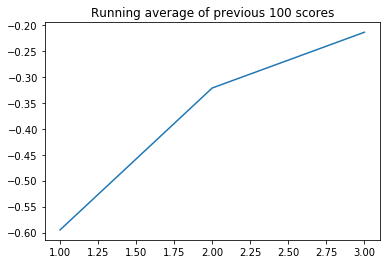

In [57]:
from environment import environment
import numpy as np
from utils import plot_learning_curve
import pandas as pd

historical_data = pd.read_csv(r'C:\Users\ratatosck\Desktop\pythonScripts\TradeBot\HistoricalData\EURUSD15.csv', sep='\t',header=None)
historical_data.drop(0, axis=1, inplace = True)
historical_data_np = historical_data.to_numpy(dtype = 'float32')

N = 20
batch_size = 5
n_epochs = 4
alpha = 0.0003
observation_size = 30

env = environment(historical_data_np, observation_size)

agent = Agent(n_actions=3, batch_size = batch_size,
             alpha = alpha, n_epochs = n_epochs, 
              input_dims1 = [observation_size, 5], input_dims2 = [2])

n_games = 3

figure_file = 'plots/PPO-v1.png'

# best_score = env.reward_range[0]
score_history = []

learn_iters = 0
avg_score = 0
n_steps = 0

for i in range(n_games):
    observation = env.reset()
    done = False
    score = 0 
    while not done:
        action, prob, val = agent.choose_action(observation)
        observation_, reward, done, info = env.step(action)
        n_steps += 1
        score += reward
        agent.remember(observation, action, prob, val, reward, done)
        if n_steps % N == 0:
            agent.learn()
            learn_iters += 1
        observation = observation_
    score_history.append(score)
    avg_score = np.mean(score_history[-100:])
        
    #tengo que ver que parametro uso para guardar el modelo.
#     if avg_score > best_score:
#         best_score = avg_score
#         agent.save_models()

    print('episode', i, 'score %.1f' %score, 'avg score %.1f' %avg_score, 
          'time_steps', n_steps, 'learning_steps', learn_iters)
        
x = [i+1 for i in range(len(score_history))]
plot_learning_curve(x, score_history, figure_file)




right now there is a bug. I have checked the shapes of the batches in the replay memory, it seems like the shapes are correct, It looks like im feeding the data into the model correctly, maybe Ill have to check step by step to see what could be wrong. something that is weird though is the output of the sigmoig is 1 on every action, this might be a clue into the identity of the problem. however I have no true idea why it is not working.